In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To address the issue of data imbalance in the target variable, I decide to use SMOTE (synthetic minority oversampling technique) and random forest to make predictions. I also tried to undersample the majority to balance the data. The latter method turned out to be better.

## Load data

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Redback_B/Heart_2022/heart_2022_no_nans.csv')

In [ ]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

## Preprocess data

In [ ]:
import pandas as pd

def get_unique_values_object_columns(dataframe):
    unique_values_dict = {}
    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            unique_values = dataframe[column].value_counts().reset_index()
            unique_values.columns = [column, 'Count']
            unique_values_dict[column] = unique_values
    return unique_values_dict

# Get unique values and counts for object columns
result = get_unique_values_object_columns(df)

# Print
for column, unique_values_df in result.items():
    print(f"Column: {column}")
    print(unique_values_df)
    print()


Column: State
                   State  Count
0             Washington  15000
1               Maryland   9165
2              Minnesota   9161
3                   Ohio   8995
4               New York   8923
5                  Texas   7408
6                Florida   7315
7                 Kansas   6145
8              Wisconsin   6126
9                  Maine   6013
10                  Iowa   5672
11                Hawaii   5596
12              Virginia   5565
13               Indiana   5502
14        South Carolina   5471
15         Massachusetts   5465
16               Arizona   5462
17                  Utah   5373
18              Michigan   5370
19              Colorado   5159
20              Nebraska   5107
21            California   5096
22           Connecticut   5053
23               Georgia   4978
24               Vermont   4845
25          South Dakota   4405
26               Montana   4264
27              Missouri   4195
28            New Jersey   3967
29         New Hampshire  

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into majority class ('No') and minority class ('Yes')
df_majority = df[df['HadHeartAttack'] == 'No']
df_minority = df[df['HadHeartAttack'] == 'Yes']

fraction_to_keep = 0.6

# Randomly sample a portion
df_majority_sampled = df_majority.sample(frac=fraction_to_keep, random_state=42)

# Combine the two to make a balanced dataset
df_balanced = pd.concat([df_minority, df_majority_sampled])

# Shuffle the rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df = df_balanced.copy()

## Model Data

In [ ]:
# Import the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Define X and y
y = df.HadHeartAttack
X = df.drop('HadHeartAttack', axis=1)

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=456)

In [ ]:
# Convert target variable into numbers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def preprocess_data(X_train, X_test):
    # Separate numerical and categorical columns
    numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
    categorical_columns = X_train.select_dtypes(include=['object']).columns

    # Normalize numerical data using StandardScaler
    scaler = StandardScaler()
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

    # Apply LabelEncoder to categorical data
    label_encoder = LabelEncoder()
    for column in categorical_columns:
        X_train[column] = label_encoder.fit_transform(X_train[column])
        X_test[column] = label_encoder.transform(X_test[column])

    return X_train, X_test

X_train_processed, X_test_processed = preprocess_data(X_train.copy(), X_test.copy())

In [ ]:
'''# Using SMOTE involves generating synthetic samples for the minority class to balance the dataset

from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.6, random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

y_train_series = pd.Series(y_train)
y_resampled_series = pd.Series(y_resampled)

print("Original class distribution:", y_train_series.value_counts())
print("Resampled class distribution:", y_resampled_series.value_counts())'''

'# Using SMOTE involves generating synthetic samples for the minority class to balance the dataset\n\nfrom imblearn.over_sampling import SMOTE\nsmote = SMOTE(sampling_strategy=0.6, random_state=42)\n\n# Apply SMOTE to the dataset\nX_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)\n\ny_train_series = pd.Series(y_train)\ny_resampled_series = pd.Series(y_resampled)\n\nprint("Original class distribution:", y_train_series.value_counts())\nprint("Resampled class distribution:", y_resampled_series.value_counts())'

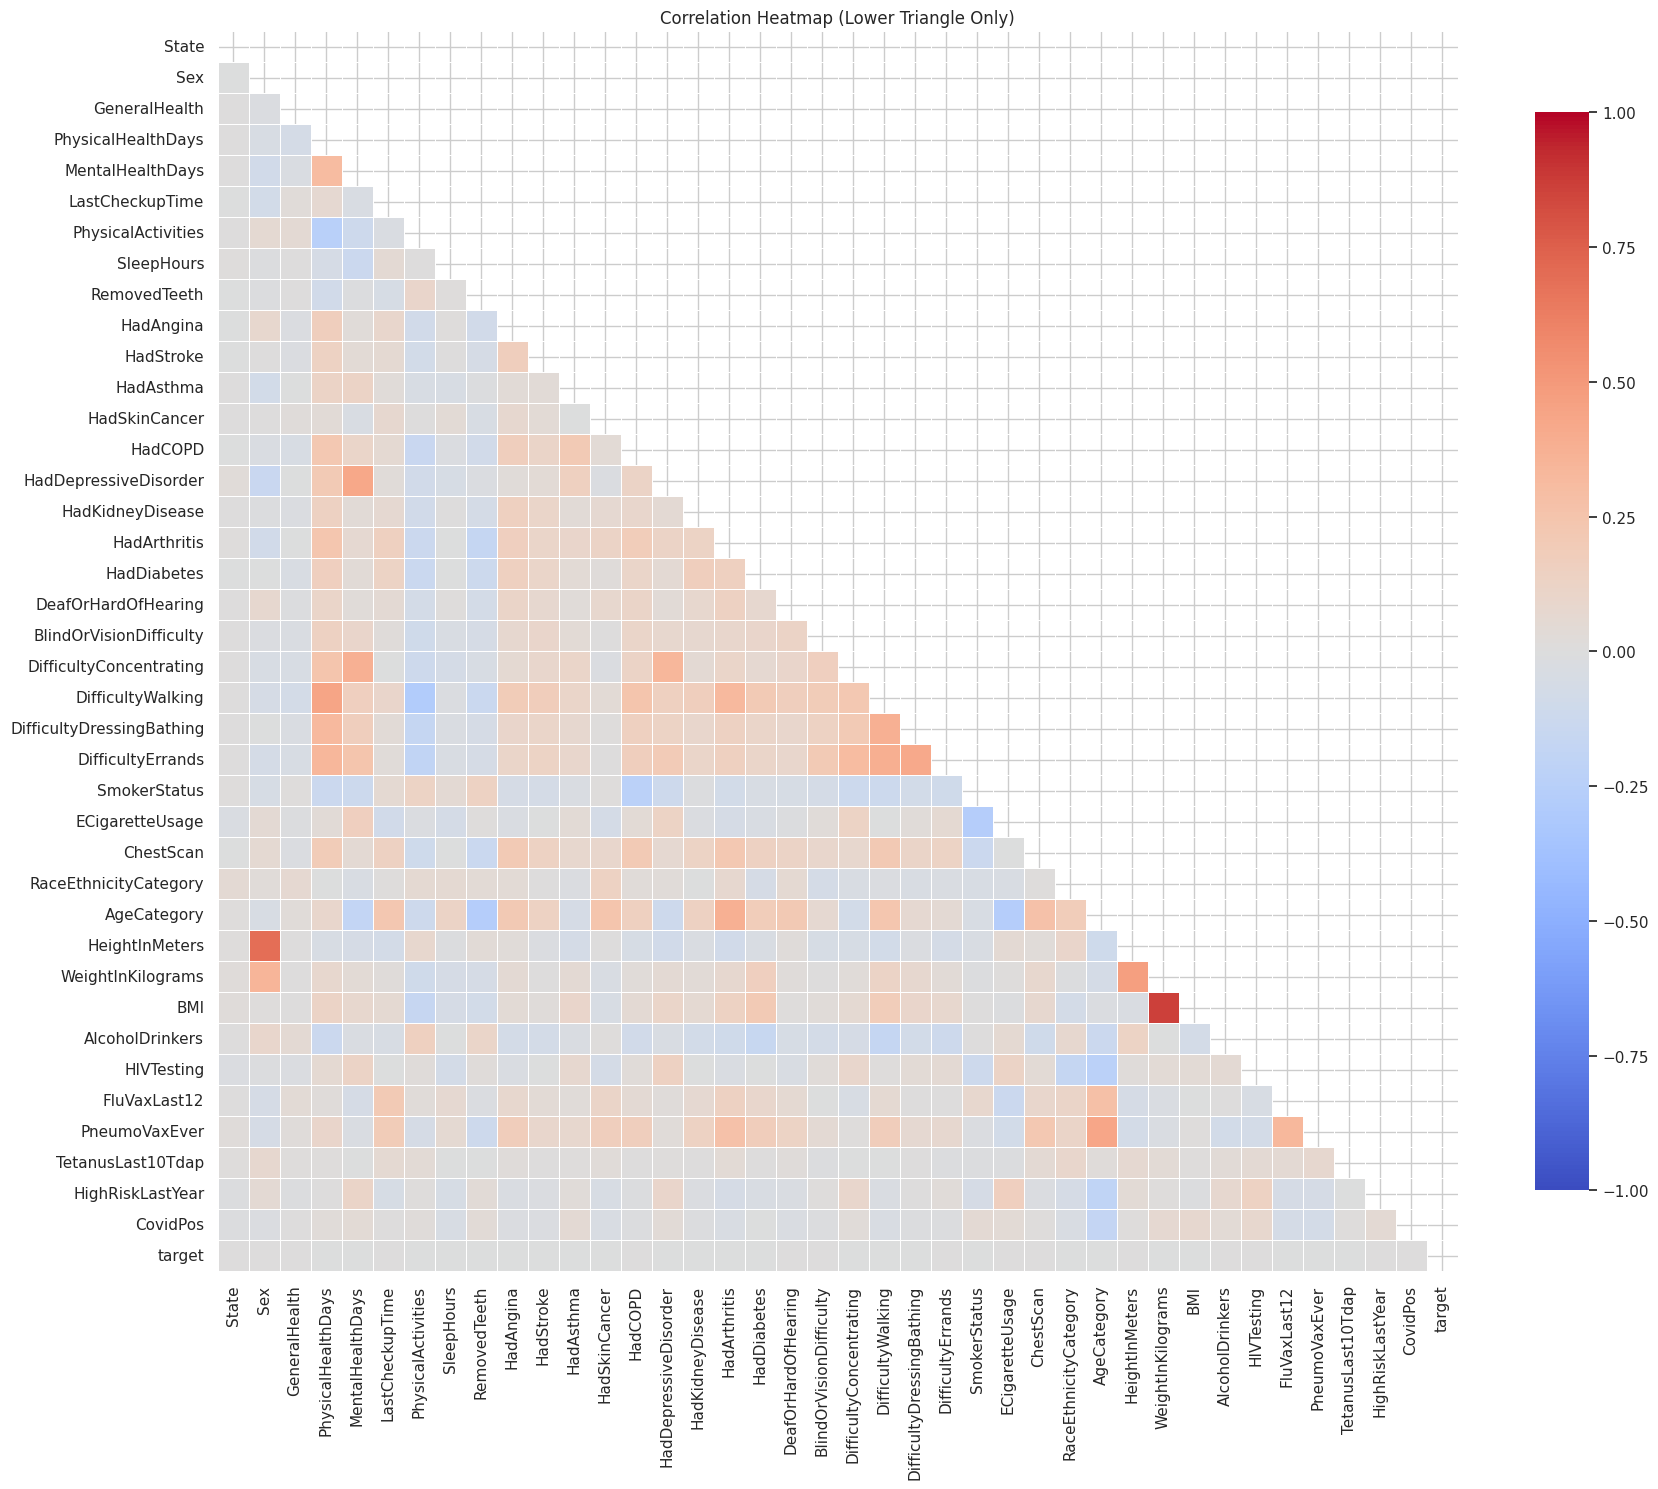

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix before oversampling
corr_matrix = pd.concat([X_train_processed, pd.Series(y_train, name='target')], axis=1).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", mask=mask,
            cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.7})

plt.title('Correlation Heatmap (Lower Triangle Only)')
plt.show()

In [ ]:
import time

# Start the timer
start_time = time.time()

In [ ]:
# create an instance of Random Forest Classifier
rf = RandomForestClassifier()

# Set the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2']
}

# Use GridSearchCV to search over the parameter grid and find the best parameter values
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=3)
grid_search.fit(X_train_processed, y_train)

# Print the best parameter values
print("Best parameters: ", grid_search.best_params_)

# Use the best parameter values to create a random forest classifier
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# perform cross-validation on the training set
cv_scores = cross_val_score(best_rf, X_train_processed, y_train, cv=3)

# print the cross-validation scores
print("Parameter values of best_rf: ", best_rf.get_params())
print("Cross-validation scores:", cv_scores)

Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Parameter values of best_rf:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Cross-validation scores: [0.92654845 0.92722077 0.92486553]


In [ ]:
# fit the model on the training set
random_forest = best_rf.fit(X_train_processed, y_train)

# Predict the labels
y_predicted = random_forest.predict(X_test_processed)

# Print accuracy score and confusion matrix on test set
print('Accuracy on the test set: ', accuracy_score(y_test, y_predicted))
print(confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy on the test set:  0.9253763862561823
[[0.89293418 0.01923873]
 [0.05538488 0.03244221]]


In [ ]:
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Elapsed time: 713.13 seconds


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Precision
precision = precision_score(y_test, y_predicted)

# Recall
recall = recall_score(y_test, y_predicted)

# F1 Score
f1 = f1_score(y_test, y_predicted)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.6277
Recall: 0.3694
F1 Score: 0.4651


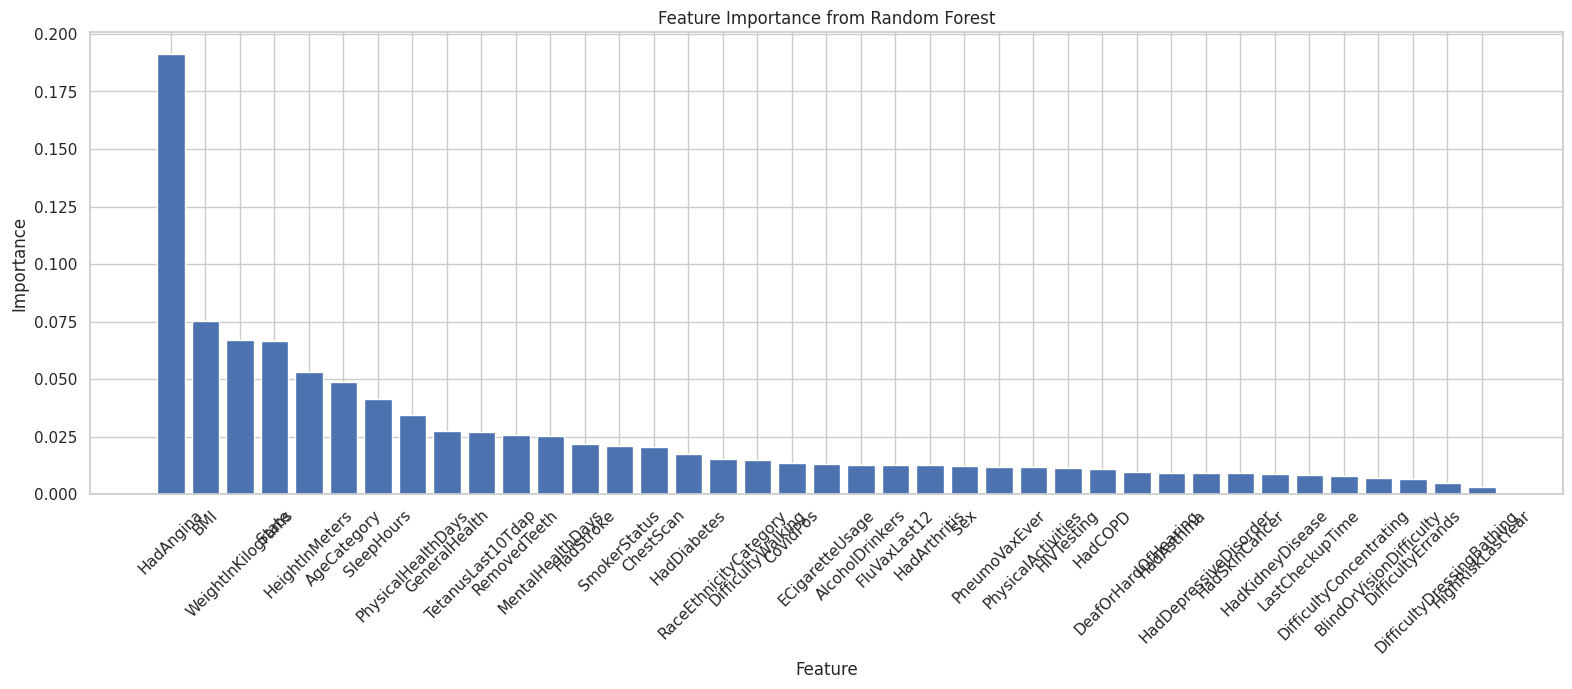

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = best_rf.feature_importances_

# Sort features in descending order of importance
import numpy as np
indices = np.argsort(feature_importances)[::-1]

# Get the feature names
feature_names = X_train_processed.columns

# Plot the feature importances
plt.figure(figsize=(19, 6))
plt.bar(range(X_train_processed.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train_processed.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()